In [456]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# we assumed that 2 dimensional shape

In [457]:
type(None) == type(None)

True

In [458]:
# variable holder 
class Variable():
    def __init__(self,inputShapes,data = None,requires_grad = True,step_size = 1):
        # keep the step size to be scalar
        self.shape = inputShapes
        self.requires_grad = True
        self.data = data.copy()
        if type(self.data) == type(None):
            self.value = np.random.rand(*self.shape) # 2d vector
        else:
            self.value = data
        self.step_size = step_size

    def forward(self):
        return self.value

    def backward(self,value):
        # print("Variable  " , value.shape)
        # print("Original " , self.value.shape)
        if(self.requires_grad):
            self.value -= self.step_size * value

In [459]:
class MatrixMul():

    def __init__(self):
        pass 

    def __call__(self):
        pass 

    def forward(self,matrixA, matrixB):
        # matrixA is of Variable type
        # matrixB is of variable type
        # self.value is always numpy array in all the classes
        self.matrixA = matrixA
        self.matrixB = matrixB
        # print("This is the matrix A : ",matrixA.value.shape)
        # print("This is the matrix B : ",matrixB.value.shape)
        self.value = self.matrixA.value @ self.matrixB.value

        return self.value

    def backward(self,value):
        # value # matrix
        # print("This is MatrixMul : " , value.shape)
        self.result1 = value @ self.matrixB.value.T # this will be passed to A
        self.result2 = self.matrixA.value.T @ value # this will be passed to B
        self.matrixA.backward(self.result1)
        self.matrixB.backward(self.result2)

        # a * b = c
        # dl/dc = matrix
        # dl/da = dl/dc . dc/da

In [460]:
class ReLU():

    def __init__(self):
        pass

    def forward(self,prevOperation):
        # lastOperation  will be the object of matrix mul
        self.prevOperation = prevOperation
        self.value = np.where(self.prevOperation.value < 0,0,self.prevOperation.value)
        # self.value values will be positive
        return self.value

    def backward(self,value):
        # print("This is ReLU : ",value.shape)
        temp = np.ones(self.value.shape)
        temp = np.where(self.value<=0,0,temp)
        self.result = temp * value
        self.prevOperation.backward(self.result)

In [461]:
class RegressionLoss():

    def __init__(self):
        pass

    def forward(self,original,predicted):
        self.original = original
        self.predicted = predicted
        self.value = np.sum((self.original.value-self.predicted.value) ** 2)
        return self.value

    def __call__(self):
        pass

    def backward(self,value):
        ## Each of this functions should call the backward function of it's calle variables.
        ## scalar value times
        ## [[1]]  1* 1

        # print("This is the Regression : ", value.shape )
        self.dldy = (self.predicted.value - self.original.value) * value
        # print("this is point" , self.dldy)
        # print("This should be of type add ", type(self.predicted))
        self.predicted.backward(self.dldy)

In [462]:
class BinaryLoss():
    def __init__(self):
        pass


    def sigmoidFunciton(self,x):
        return np.reciprocal(np.exp(x * -1))

    def backwardSigmoidFunction(self,value):
        #TODO
        pass

    def forward(self,original,predicted):
        self.original = original
        self.predicted = predicted
        self.logits =  self.sigmoidFunciton(self.predicted)
        #TODO: Compute the binary loss
        self.value = np.sum(self.original * np.log(self.logits) * -1 + -1 * np.log(1- self.logits) * (1-self.original))
        print(self.logits)
        print(self.value)
        return self.value

    def __call__(self):
        pass

    def backward(self,value):
        ## Each of this functions should call the backward function of it's calls variables.
        ## scalar value times
        ## [[1]]  1* 1
        #TODO

        pass


In [463]:
class Add():
    def __init__(self):
        pass

    def forward(self, f_input1, f_input2):
        self.f_input1 = f_input1
        self.f_input2 = f_input2
        self.value = f_input1.value + f_input2.value
        return self.value

    def backward(self, b_grad):
        # print("This is the Addition : ",b_grad.shape)
        self.grad = b_grad * np.ones(self.value.shape)

        self.f_input2.backward(self.grad)
        self.f_input1.backward(self.grad)

        # self.grad = b_grad * 1 #Addition
        return self.grad

In [464]:
# for bias
class Bias(Variable):

     def backward(self,value):
         self.update = np.sum(value,axis = 0)
         self.value -= self.update * self.step_size

In [465]:
# optional if needed 
class Linear():
    def __init__(self,weight, bias,activation_function = False):
        # weight and bias should be of type Variable
        # activation_function True means we are using ReLU
        self.weight = weight
        self.bias = bias
        self.addition = Add()
        self.matmul = MatrixMul()
        self.activation_function = activation_function
        if(self.activation_function):
            self.activation = ReLU()

    def forward(self,x):
        self.input = x
        self.value = self.matmul.forward(x,self.weight)
        self.value = self.addition.forward(self.matmul,self.bias)
        self.finalOperation = self.addition
        if(self.activation_function):
            self.value = self.activation.forward(self.addition)
            self.finalOperation = self.activation
        return self.finalOperation

    def backward(self,grad):
        # print("This is linear Linear : ", grad.shape)
        if self.activation_function:
            self.activation.backward(grad)
        else:
            self.addition.backward(grad)

In [480]:
def dataloader():
    with open('assignment-one-test-parameters.pkl','rb') as f:
        data = pickle.load(f)
    inputs = data["inputs"]
    w1 = data["w1"]
    w2 = data["w2"]
    w3 = data["w3"]
    b1 = data["b1"]
    b2 = data["b2"]
    b3 = data["b3"]
    targets = np.reshape(data["targets"],(data["targets"].shape[0],1))
    params = {
        "w1" : w1.T,
        "w2" : w2.T,
        "w3" : w3.T,
        "b1" : np.reshape(b1,(1,b1.shape[0])),
        "b2" : np.reshape(b2,(1,b2.shape[0])),
        "b3" : np.reshape(b3,(1,b3.shape[0])),
    }
    trainset = (inputs, targets)

    return trainset, params


In [481]:
trainset,params  = dataloader()

In [482]:
trainset[0].shape

(200, 2)

In [492]:
step_size = 0.001
w1 = Variable(params["w1"].shape,data= params["w1"],step_size=step_size)
w2 = Variable(params["w2"].shape,data = params["w2"],step_size=step_size)
w3 = Variable(params["w3"].shape,data = params["w3"],step_size=step_size)
b1 = Bias(params["b1"].shape,data = params["b1"],step_size=step_size)
b2 = Bias(params["b2"].shape,data = params["b2"],step_size=step_size)
b3 = Bias(params["b3"].shape,data = params["b3"],step_size=step_size)

# w1 = Variable(params["w1"].shape,data= None,step_size=step_size)
# w2 = Variable(params["w2"].shape,data = None,step_size=step_size)
# w3 = Variable(params["w3"].shape,data = None,step_size=step_size)
# b1 = Bias(params["b1"].shape,data = None,step_size=step_size)
# b2 = Bias(params["b2"].shape,data = None,step_size=step_size)
# b3 = Bias(params["b3"].shape,data = None,step_size=step_size)

In [493]:
print("w1 shape : ",w1.value.shape)
print("w2 shape : ",w2.value.shape)
print("w3 shape : ",w3.value.shape)

w1 shape :  (2, 10)
w2 shape :  (10, 10)
w3 shape :  (10, 1)


In [494]:
w1.shape

(2, 10)

In [495]:
b1.shape

(1, 10)

In [496]:
def get_baches(x,y,batch_size):
    # shuffle the dataset
    number_of_steps = x.shape[0] // batch_size


    #TODO: shuffle the dataset
    # pass the dataset
    start = 0
    end = batch_size
    for i in range(number_of_steps):
        x_final = Variable(x[start : end].shape,x[start : end],requires_grad=False)
        y_final  = Variable(y[start : end].shape,y[start:end], requires_grad=False)
        start += batch_size
        end += batch_size
        yield (x_final,y_final)
    if(end > x.shape[0] and start < x.shape[0]):
        x_final = Variable(x[start :].shape,x[start:],requires_grad=False)
        y_final  = Variable(y[start :].shape,y[start:], requires_grad=False)
        yield (x_final,y_final)

In [497]:
x = trainset[0]
y = trainset[1]
total = 0
k = 30
for x,y in get_baches(x,y,32):
    print(x.value.shape)
    total += x.value.shape[0]
    k-=1
    if(k == 0):
        break
print("This is the total : ",total)

(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(8, 2)
This is the total :  200


In [498]:
# training loop
n_epochs = 10
batch_size = 10

# x = Variable(trainset[0].shape,trainset[0],requires_grad=False)
# y_true = Variable(trainset[1].shape,trainset[1],requires_grad=False)

# Initialize the netword
Linear1 = Linear(w1,b1,True)
Linear2 = Linear(w2,b2,True)
Linear3 = Linear(w3,b3,False)
loss = RegressionLoss()

# bookeeping the losses
losses = []

# run through each of the epochs
for _ in range(n_epochs):

    for x,y_true in get_baches(trainset[0],trainset[1],batch_size=batch_size):
        # forward pass
        y = Linear1.forward(x)
        y = Linear2.forward(y)
        y = Linear3.forward(y)

        loss_value = loss.forward(y_true,y)

        losses.append(loss_value)

        # backward pass
        loss.backward(np.array([[1]]))

In [499]:
losses

[2.9827685399736668,
 4.5289242925786946,
 3.6469274398998097,
 3.9867186063491333,
 1.924821043628775,
 3.1814609111483865,
 5.050421563745324,
 2.130479777062683,
 3.678989228639933,
 3.950861367114333,
 2.5602704273414574,
 3.852165497817349,
 2.032648932260374,
 5.248280354617673,
 2.565133765721448,
 5.098367084509727,
 5.468881922107826,
 1.8917914968987408,
 3.6634429412555387,
 4.573418654735643,
 2.8187754437440664,
 4.3881259266149195,
 3.410166331906412,
 3.745556057746482,
 1.813137099778361,
 3.0588019834196745,
 4.768765395606493,
 2.0514997620572064,
 3.4855799023431486,
 3.7168866177408253,
 2.3436115021398445,
 3.6454275155838465,
 1.9124956635899348,
 5.014838941323233,
 2.3979367370430515,
 4.818832263175119,
 5.046268487174276,
 1.734767240129562,
 3.4711639077086036,
 4.243308984092416,
 2.5974157575725902,
 4.199209926269724,
 3.0970173326942385,
 3.457278703096567,
 1.6552186428365818,
 2.9058787247135687,
 4.409763169992054,
 1.9469880028532218,
 3.2448658939703

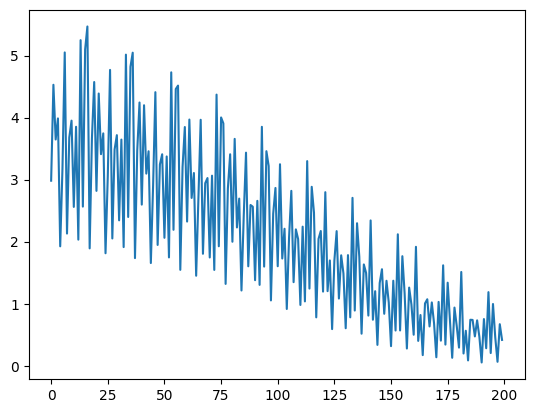

In [500]:
plt.plot(np.arange(len(losses)),losses)

In [305]:
## Linear layers
# Test Run

Linear1 = Linear(w1,b1,True)
Linear2 = Linear(w2,b2,True)
Linear3 = Linear(w3,b3,False)
x = Variable(trainset[0].shape,trainset[0],requires_grad=False)

y = Linear1.forward(x)
y = Linear2.forward(y)
y = Linear3.forward(y)
loss = RegressionLoss()
y_true = Variable(trainset[1].shape,trainset[1],requires_grad=False)
loss.forward(y_true,y)

107.60015998278625

In [37]:
y.value.shape

(200, 1)

In [38]:
loss.backward(np.array([[1]]))
# here the backward pass the shape is (200,1)
# I have just one bias term
# during the backward pass what will be the shape
#

In [58]:
# Initializing variables
A = Variable((10,2)) # assuming here that
# here 10 are the number of examples and 2 are the features
w1 = Variable((2,1)) # the first layer is assumed to be creating the neurons of 5 in size

# Matrix multiplication
h1 = MatrixMul()
res = h1.forward(A,w1) # 10,1

# Computing the ReLU
o1 = ReLU() # 10,1
o1.forward(h1)

# Computing the loss
loss = RegressionLoss()
y = Variable((10,1))
loss.forward(y,o1)

# print(loss.value)

loss.backward(np.array([[1]]))




Reached till Regression loss  [[1]]
this is point [[ 0.5119473 ]
 [ 0.25303018]
 [-0.15150328]
 [ 0.41348196]
 [ 0.2878462 ]
 [-0.24015475]
 [ 0.1195707 ]
 [ 0.20373379]
 [ 0.34159231]
 [ 0.55075722]]
First Gradient  (10, 2)
First Gradient  (2, 1)
[[ 0.5119473 ]
 [ 0.25303018]
 [-0.15150328]
 [ 0.41348196]
 [ 0.2878462 ]
 [-0.24015475]
 [ 0.1195707 ]
 [ 0.20373379]
 [ 0.34159231]
 [ 0.55075722]]


In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_d(x):
    return (x > 0).astype(float)

In [ ]:
### Goal 
# feel free to change the structure as you the need be
# This are just my initial thoughts 
# A = varialbe(n,m)
# w1 = variable(n,m)
# h1 = Matmul(A,w1)
# o1 = ReLu(h1)
# w2 = variable(n,m)
# h2 = Matmul(o1,w2)
# w3 = variable(n,m)
# loss = RegLoss(Matmul(h2,w3))
# loss.backward()